# Part 2 – REPORTINGOWNER.tsv Exploratory Data Analysis

This notebook analyzes **REPORTINGOWNER.tsv** to understand who the reporting owners are and how they are categorized.
Key goals:
- Inspect structure and missingness
- Analyze distribution of `RPTOWNER_RELATIONSHIP`
- Group roles into simplified categories (e.g., Officer, Director, 10% Owner)
- Visualize the composition of reporting owners

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load data
Update `REPORTINGOWNER_PATH` as needed for your environment.

In [3]:
REPORTINGOWNER_PATH = r"/Users/aaniaadap/Desktop/KDDM Project/Dataset/REPORTINGOWNER.tsv"  # <-- update this

df_owner = pd.read_csv(REPORTINGOWNER_PATH, sep='\t', low_memory=False)
df_owner.head()

,ACCESSION_NUMBER,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_TITLE,RPTOWNER_TXT,RPTOWNER_STREET1,RPTOWNER_STREET2,RPTOWNER_CITY,RPTOWNER_STATE,RPTOWNER_ZIPCODE,RPTOWNER_STATE_DESC,FILE_NUMBER
0,0001104659-25-030101,1449433,"Apollo Management Holdings GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
1,0001104659-25-030101,1413410,"Apollo Management GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
2,0001104659-25-030101,1449434,"Apollo Management Holdings, L.P.",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
3,0001104659-25-030099,1934842,"College Parent Holdings GP, LLC",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566
4,0001104659-25-030099,1784683,"Apollo Management IX, L.P.",TenPercentOwner,NaN,NaN,"9 WEST 57TH STREET, 43RD FLOOR",NaN,NEW YORK,NY,10019,NaN,001-40566


## 2. Basic info and missing values
We first examine the shape, data types, and missing values to assess data quality.

In [4]:
print('Shape:', df_owner.shape)
df_owner.dtypes

Shape: (66287, 13)


ACCESSION_NUMBER         object
RPTOWNERCIK               int64
RPTOWNERNAME             object
RPTOWNER_RELATIONSHIP    object
RPTOWNER_TITLE           object
RPTOWNER_TXT             object
RPTOWNER_STREET1         object
RPTOWNER_STREET2         object
RPTOWNER_CITY            object
RPTOWNER_STATE           object
RPTOWNER_ZIPCODE         object
RPTOWNER_STATE_DESC      object
FILE_NUMBER              object
dtype: object

In [5]:
missing = df_owner.isnull().sum()
missing_pct = (missing / len(df_owner) * 100).round(2)
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

,Missing Count,Missing %
ACCESSION_NUMBER,0,0.00
RPTOWNERCIK,0,0.00
RPTOWNERNAME,0,0.00
RPTOWNER_RELATIONSHIP,27,0.04
RPTOWNER_TITLE,22589,34.08
RPTOWNER_TXT,64629,97.50
RPTOWNER_STREET1,270,0.41
RPTOWNER_STREET2,28007,42.25
RPTOWNER_CITY,29,0.04
RPTOWNER_STATE,104,0.16


## Relationship type distribution
We look at `RPTOWNER_RELATIONSHIP` to understand what kinds of roles are most common among reporting owners.

In [6]:
rel_col = 'RPTOWNER_RELATIONSHIP'
relationship_counts = df_owner[rel_col].value_counts(dropna=False)
relationship_counts.head(20)

RPTOWNER_RELATIONSHIP
Officer                                   34785
Director                                  16506
Director,Officer                           7385
TenPercentOwner                            3492
Director,Officer,TenPercentOwner           1297
Director,TenPercentOwner                   1107
Other                                      1101
Director,Other                              204
TenPercentOwner,Other                       108
Officer,Other                               106
Director,Officer,Other                       55
Director,TenPercentOwner,Other               54
Officer,TenPercentOwner                      35
NaN                                          27
Director,Officer,TenPercentOwner,Other       13
Officer,TenPercentOwner,Other                12
Name: count, dtype: int64

### Simplified role categories
We map the detailed relationship strings into broader categories, such as:
- **Officer Only**
- **Director Only**
- **10% Owner Only**
- **Officer & Director**
- **Other / Multiple**

This helps interpret the mix of insider types.

In [16]:
def categorize_role(rel: str) -> str:
    if not isinstance(rel, str):
        return 'Unknown'
    r = rel.upper()
    is_officer = 'OFFICER' in r
    is_director = 'DIRECTOR' in r
    is_owner = '10%' in r or '10% OWNER' in r

    if is_officer and not is_director and not is_owner:
        return 'Officer Only'
    if is_director and not is_officer and not is_owner:
        return 'Director Only'
    if is_owner and not is_officer and not is_director:
        return '10% Owner Only'
    if is_officer and is_director and not is_owner:
        return 'Officer & Director'
    if is_owner and (is_officer or is_director):
        return 'Owner & Officer/Director'
    return 'Other/Multiple'

df_owner['role_category'] = df_owner[rel_col].apply(categorize_role)
simplified_counts = df_owner['role_category'].value_counts()
simplified_counts

role_category
Officer Only          34938
Director Only         17871
Officer & Director     8750
Other/Multiple         4728
Name: count, dtype: int64

### Detailed role frequency (handling multi-role entries)

We now break down `RPTOWNER_RELATIONSHIP` into individual roles.
This helps us see how often labels like "OFFICER", "DIRECTOR",
"10% OWNER", etc. appear across all reporting owners,
even when multiple roles are combined in one field.


In [17]:
# Ensure relationship column is string and uppercased
df_owner['RPTOWNER_RELATIONSHIP'] = df_owner['RPTOWNER_RELATIONSHIP'].fillna('').str.upper()

# Split on common delimiters (comma, semicolon, slash)
df_owner['role_list'] = df_owner['RPTOWNER_RELATIONSHIP'].str.split(r'[,;/]')

# Explode into one role per row
roles_exploded = df_owner.explode('role_list')
roles_exploded['role_list'] = roles_exploded['role_list'].str.strip()
roles_exploded = roles_exploded[roles_exploded['role_list'] != '']

# Count individual role tokens
role_counts = roles_exploded['role_list'].value_counts().head(20)
role_counts


role_list
OFFICER            43688
DIRECTOR           26621
TENPERCENTOWNER     6118
OTHER               1653
Name: count, dtype: int64

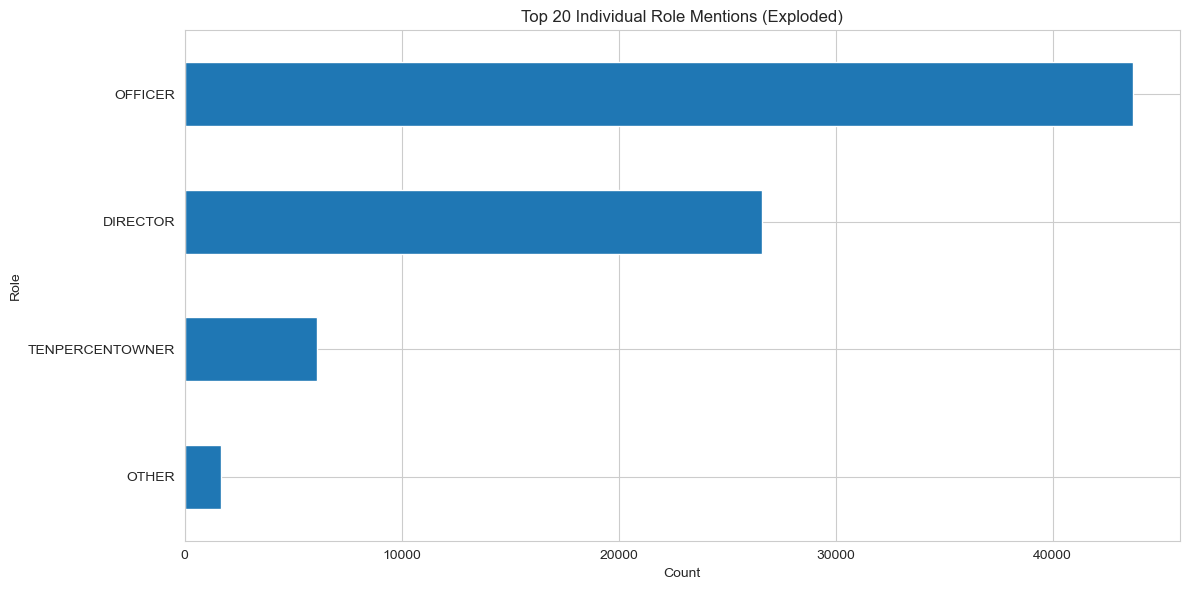

In [11]:
plt.figure()
role_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Individual Role Mentions (Exploded)')
plt.xlabel('Count')
plt.ylabel('Role')
plt.tight_layout()
plt.show()


### Visualizations
We visualize:
- Top relationship types
- Distribution of simplified role categories

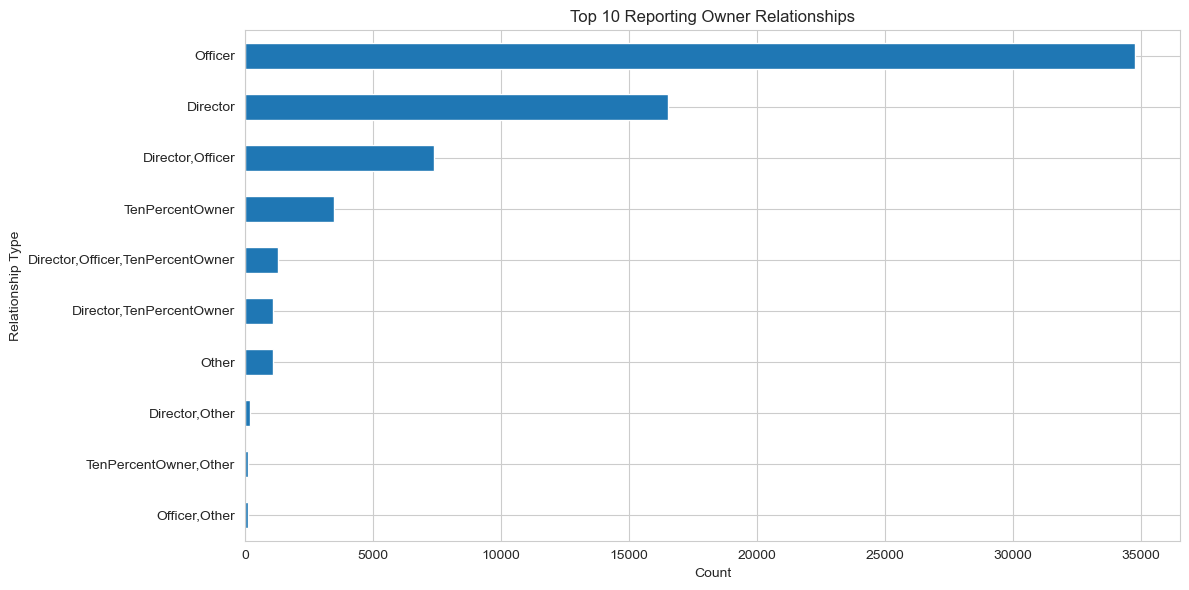

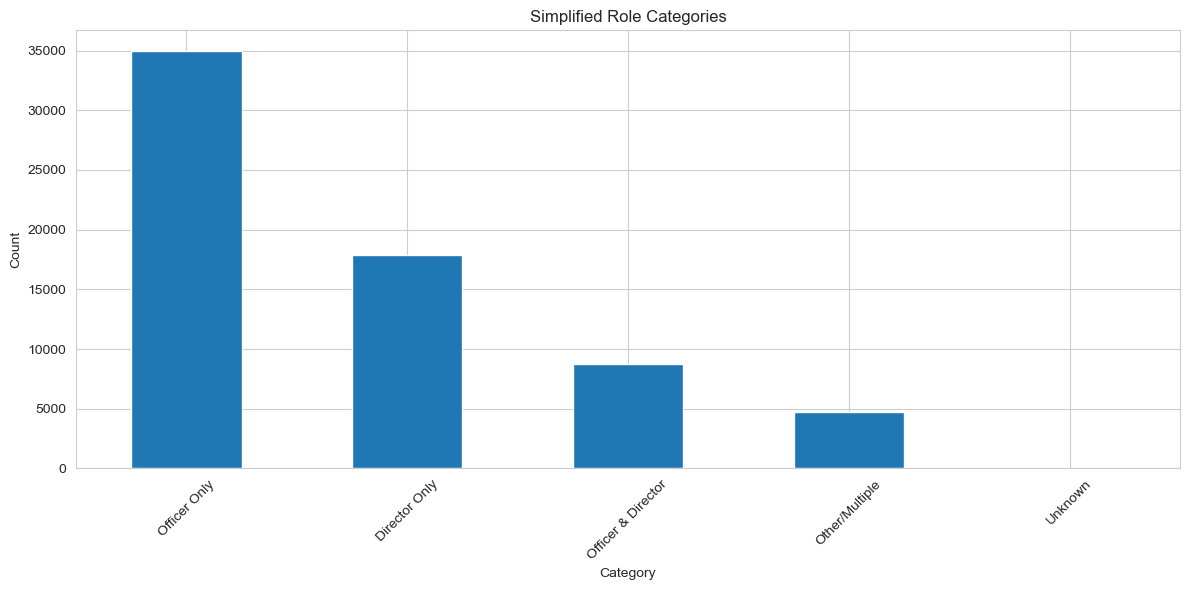

In [8]:
plt.figure()
relationship_counts.head(10).plot(kind='barh')
plt.title('Top 10 Reporting Owner Relationships')
plt.xlabel('Count')
plt.ylabel('Relationship Type')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure()
simplified_counts.plot(kind='bar')
plt.title('Simplified Role Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import math

def compute_E(N, K):
    E = [[0]*(K+1) for _ in range(N+1)]
    for k in range(1, K+1):
        E[0][k] = 0
    for n in range(0, N+1):
        E[n][1] = n
    for k in range(2, K+1):
        for n in range(1, N+1):
            best = math.inf
            for i in range(1, n+1):
                worst = 1 + max(E[i-1][k-1], E[n-i][k])
                if worst < best:
                    best = worst
            E[n][k] = best
    return E

# Example:
E = compute_E(5, 3)
print("E(5,3) =", E[5][3])
for n in range(6):
    print(n, E[n][1:4])


E(5,3) = 3
0 [0, 0, 0]
1 [1, 1, 1]
2 [2, 2, 2]
3 [3, 2, 2]
4 [4, 3, 3]
5 [5, 3, 3]
